<a href="https://colab.research.google.com/github/lasupernova/Tensorflow_apps/blob/master/SciAbstractClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An NLP model that makes reading scientific abstract easier by separating an abstract into 5 parts.

 - Background
 - Objectives
 - Methods
 - Results
 - Conclusion

The model aims to replicate and modify (improved) the models built in the following paper:
https://arxiv.org/abs/1710.06071

In [1]:
#check access to GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



The PubMed 200k RCT dataset (https://github.com/Franck-Dernoncourt/pubmed-rct)  will be used for training the model, based on the following paper:

https://arxiv.org/abs/1710.06071

In [2]:
#download data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
#imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf

## Model using 10% of data set

In [4]:
#check pubmed_20k_rct dataset files
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


NOTE: <br>
train.txt - train dataset<br>
test.txt - test dataset<br>
dev.txt - validation dataset<br>

In [5]:
DATA_DIR = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [6]:
#get list of filenames in dir
f_names = [f"{DATA_DIR}{os.sep}{f_name}" for f_name in os.listdir(DATA_DIR)]
f_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

### Pre-process data

In [18]:
#read data into variables
def import_data_from_txt(f_name):
  """
  Read data contained in specified file and save data (text) to variable to.

  PARAMS:
    f_name(str) - path to file

  RETURNS:
    data(lst) - list with text data save as entries
  """
  extension = f_name.split(".")[-1]
  if extension != "txt":
    print("ERROR! Extension of type .txt required!")
  with open(f_name, "r") as f:
    return f.readlines()

In [19]:
# for file in f_names:
#   name = file.split("/")[-1].split(".")[0]
#   name = 

In [20]:
train_data = import_data_from_txt('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
test_data = import_data_from_txt('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')
val_data = import_data_from_txt('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')

In [21]:
train_data[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [24]:
#create list of dicts to store data in 
def preprocess_data(f_name):
    """
    Get information from text file specified.
    Read data contained in data list into list of dicts, with every data list entry being represented by a dict.

    PARAMS:
      f_name(str) - path to file

    RETURNS:
      lstOdct(lst) - list of dicts
    """
    data = import_data_from_txt(f_name)
    line_counter = 0
    lstOdct = []
    for entry in data:
      if entry.startswith("###"):
        line_counter = 1
        new_abstract = []
      elif entry == "\n":
        line_counter = 0
        #get line count for current abstract
        total_lines = len(new_abstract)
        #append line count for current abstract to each dict in sublist
        new_abstract = [dict(item, **{'total_lines':total_lines}) for item in new_abstract]
        #add current abstract entries to lstOdct
        lstOdct.extend(new_abstract)
      else:
        label, sentence = entry.strip().split("\t")
        curr_dict = {
            "line_num" : line_counter,
            "label" : label.lower(),
            "text" : sentence.lower()
        }
        new_abstract.append(curr_dict)
        line_counter  += 1
    return lstOdct

In [25]:
%%time
train_dct = preprocess_data('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
test_dct = preprocess_data('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')
val_dct = preprocess_data('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')

CPU times: user 530 ms, sys: 164 ms, total: 694 ms
Wall time: 696 ms


In [26]:
train_dct[:5]

[{'label': 'objective',
  'line_num': 1,
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 12},
 {'label': 'methods',
  'line_num': 2,
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 12},
 {'label': 'methods',
  'line_num': 3,
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 12},
 {'label': 'methods',
  'line_num': 4,
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 12},
 {'label': 'methods',
  'line_num': 5,
  'text': 'secondary outcome measures included the western ontari

In [27]:
#convert list of dicts into DataFrame in order to visualize
train_df = pd.DataFrame(train_dct)
test_df = pd.DataFrame(test_dct)
val_df = pd.DataFrame(val_dct)
train_df.head(20)

,line_num,label,text,total_lines
0,1,objective,to investigate the efficacy of @ weeks of dail...,12
1,2,methods,a total of @ patients with primary knee oa wer...,12
2,3,methods,outcome measures included pain reduction and i...,12
3,4,methods,pain was assessed using the visual analog pain...,12
4,5,methods,secondary outcome measures included the wester...,12
5,6,methods,"serum levels of interleukin @ ( il-@ ) , il-@ ...",12
6,7,results,there was a clinically relevant reduction in t...,12
7,8,results,the mean difference between treatment arms ( @...,12
8,9,results,"further , there was a clinically relevant redu...",12
9,10,results,these differences remained significant at @ we...,12


In [28]:
# check what the distribution of abstract length is
len_distrib_sorted = train_df.total_lines.value_counts().sort_values(ascending=False).to_frame()

In [29]:
# check what the distribution of abstract length is
len_distrib = train_df.total_lines.value_counts().to_frame().sort_index()

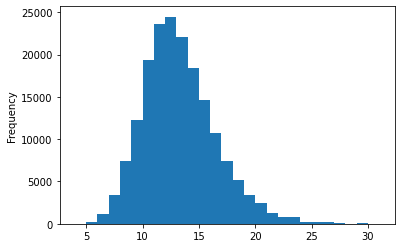

In [30]:
train_df.total_lines.plot.hist(bins=len(len_distrib))
plt.show()

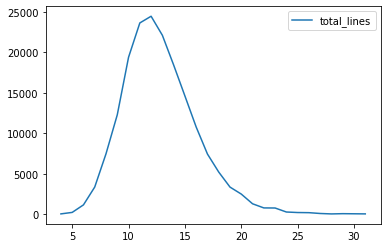

In [31]:
len_distrib.plot()
plt.show()

In [32]:
# check what the distribution of abstract labels is
label_distrib = train_df.label.value_counts()

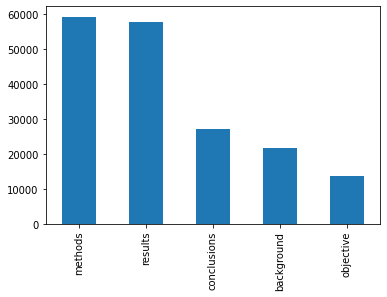

In [33]:
label_distrib.plot(kind="bar")
plt.show() 


### Encode data

 - save text (x) and labels (y) to separate lists to pass on to ML model later on
 -convet labels to numeric form using OneHotEncoding

In [34]:
X_train = train_df["text"].to_list()
X_test = test_df["text"].to_list()
X_val = val_df["text"].to_list()
len(X_train), len(X_test), len(X_val)

(180040, 30135, 30212)

In [35]:
y_train = train_df["label"].to_list()
y_test = test_df["label"].to_list()
y_val = val_df["label"].to_list()
len(y_train), len(y_test), len(y_val)

(180040, 30135, 30212)

In [36]:
X_train[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [37]:
y_train[:5]

['objective', 'methods', 'methods', 'methods', 'methods']

In [38]:
#get indeces -  convert to array to be ableto use with sklearn OneHotEncoder
labels = np.array(y_train)

In [39]:
labels

array(['objective', 'methods', 'methods', ..., 'results', 'conclusions',
       'conclusions'], dtype='<U11')

##### One-hot Encoding

In [40]:
#one hot encode labels - non-sparse matrix in order to be compatible with tf.constant()
enc = OneHotEncoder(sparse=False)

In [41]:
encoded_train_labels = enc.fit_transform(labels.reshape(-1, 1)) #fit to training labels AND trasnform those labels

In [42]:
encoded_train_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [43]:
tf.constant(encoded_train_labels)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [44]:
#use fit_transformed encoder to also trasnform validation and test labels
encoded_test_labels = enc.transform(np.array(y_test).reshape(-1,1)) #encoder was already fitted (to training labels) - transform test and val labels now
encoded_val_labels = enc.transform(np.array(y_val).reshape(-1,1)) 

##### Label Encoding

In [45]:
label_enc = LabelEncoder()
lab_encoded_train_labels = label_enc.fit_transform(labels.reshape(-1, 1))
lab_encoded_test_labels = label_enc.transform(np.array(y_test).reshape(-1,1)) #encoder was already fitted (to training labels) - transform test and val labels now
lab_encoded_val_labels = label_enc.transform(np.array(y_val).reshape(-1,1)) 

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
lab_encoded_train_labels[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

##### Get class names from encoder

--> this could be done with any of the two encoders, but here the information in extracted from OneHotEncoder instance (enc)

In [ ]:
#get class names and numbers from encoder
num_classes = len(enc.categories_)
classes = enc.categories_
classes

## Train Models

Different models will be tried, including:<br>
 - sklearn's NaiveBayes (tf-idf) encoder <br>
 - TensorFlow Hub Pretrained Feature Extractor<br>
 - Conv1D with character embeddings<br>
 - Pretrained token embeddings (same as 2nd model from above) + charater embeddings (same as 3rd from above)<br>
 - Pretrained token embeddings (same as 2nd model from above) + charater embeddings (same as 3rd from above) + positional embeddings



### Naive Bayes (tf-idf)

In [ ]:
##